In [2]:
import pandas as pd
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy.stats import t

In [3]:
# This is to be able to find and read all the csv that are in the folder files

Files_Path = (Path.cwd())
Files_Path = str(Files_Path) + "\\files"
Files_Path = Path(Files_Path)

In [4]:
def read_csv(i):
    onlyfiles = [f for f in listdir(Files_Path) if isfile(join(Files_Path, f))]
    csv_path = Path(str(Files_Path) + "\\" +  onlyfiles[i])
    df = pd.read_csv(csv_path)
    return df

In [5]:
call_dataset = read_csv(0)
clv_dataset = read_csv(1)
customer_dataset = read_csv(2)
lead_dataset =  read_csv(3)
marketing_cost_dataset = read_csv(4)
sales_cost_dataset = read_csv(5)

lead_dataset_conversion_rate = lead_dataset
customer_dataset_conversion_rate = customer_dataset
call_dataset_conversion_rate = call_dataset

C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\3148348902.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [6]:
lead_dataset['create_date'] = pd.to_datetime(lead_dataset['create_date'])

lead_dataset['year'] = pd.DatetimeIndex(lead_dataset['create_date']).year
lead_dataset['month'] = pd.DatetimeIndex(lead_dataset['create_date']).month




In [7]:
lead_dataset = lead_dataset.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['create_date']].count().rename(columns={"create_date": "number_leads"})

# here we get the number of leads that we got per month and marketing source



In [8]:
marketing_cost_dataset[['year', 'month']] = marketing_cost_dataset['date'].str.split('-', 1, expand=True)

marketing_cost_dataset['year'] = marketing_cost_dataset['year'].astype('int')

marketing_cost_dataset['month'] = marketing_cost_dataset['month'].astype('int')

C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\2859999446.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  marketing_cost_dataset[['year', 'month']] = marketing_cost_dataset['date'].str.split('-', 1, expand=True)


In [9]:
marketing_cost_dataset = marketing_cost_dataset[['year', 'month', 'marketing_source', 'marketing_costs']]

In [10]:
CPAs = marketing_cost_dataset.merge(lead_dataset, how='inner', on=['year', 'month', 'marketing_source'])

CPAs['cpa_lead'] = CPAs['marketing_costs'] / CPAs['number_leads'] 

CPAs

# in here we can analyse how much is the cost per lead per marketing source

# Later on, we are going to analyse how is the conversion rate per marketing source (how many leads become a customer.
# In this way, we can see Conversion rate and see how good are the leads per source)

,year,month,marketing_source,marketing_costs,number_leads,cpa_lead
0,2022,12,Google,290778.81710,18332,15.861816
1,2022,12,Meta,90817.26102,5646,16.085239
2,2022,12,Other,37478.39045,19047,1.967679
3,2023,1,Google,638479.14410,34532,18.489492
4,2023,1,Meta,228215.28390,14067,16.223451
5,2023,1,Other,52146.61351,31127,1.675286
6,2023,2,Google,427030.12580,36784,11.609127
7,2023,2,Meta,229156.82790,10704,21.408523
8,2023,2,Other,51336.59722,14201,3.614999
9,2023,3,Google,210264.49570,18455,11.393362


In [11]:
grouped_CPAs = CPAs.groupby(by=['year', 'month'], as_index=False)[['number_leads']].sum().rename(columns={"number_leads": "total_leads_month"})

CPAs = CPAs.merge(grouped_CPAs, how='inner', on=['year', 'month']) 

In [12]:
CPAs["weight"] = CPAs["number_leads"] / CPAs["total_leads_month"] 

sales_cost_dataset[['year', 'month']] = sales_cost_dataset['Month'].str.split('-', 1, expand=True)

sales_cost_dataset = sales_cost_dataset[['year', 'month', 'Total Sales Costs', 'Trial Costs']]

sales_cost_dataset['year'] = sales_cost_dataset['year'].astype('int')

sales_cost_dataset['month'] = sales_cost_dataset['month'].astype('int')

C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\2842337350.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  sales_cost_dataset[['year', 'month']] = sales_cost_dataset['Month'].str.split('-', 1, expand=True)


In [13]:
lead_dataset =  read_csv(3)

call_dataset = read_csv(0)

call_dataset = call_dataset[(call_dataset.trial_booked == 1)].reset_index(drop=True)

call_dataset = call_dataset[['contact_id']]

call_dataset = call_dataset.merge(lead_dataset, how='inner', on=['contact_id']) 

call_dataset['create_date'] = pd.to_datetime(call_dataset['create_date'])

call_dataset['year'] = pd.DatetimeIndex(call_dataset['create_date']).year
call_dataset['month'] = pd.DatetimeIndex(call_dataset['create_date']).month


total_trials = call_dataset.groupby(by=['year', 'month'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "total_leads_trials"})

call_dataset = call_dataset.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "leads_trials"})

call_dataset = call_dataset.merge(total_trials, how='inner', on=['year', 'month']) 

call_dataset['weight_trials'] = call_dataset['leads_trials'] / call_dataset['total_leads_trials']

call_dataset = call_dataset[['year', 'month', 'marketing_source', 'weight_trials']]

C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\3148348902.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [14]:
CPAs = CPAs.merge(sales_cost_dataset, how='inner', on=['year', 'month']) 

CPAs = CPAs.merge(call_dataset, how='inner', on=['year', 'month', 'marketing_source']) 

CPAs['Trial Costs'] = CPAs['Trial Costs'] * CPAs['weight_trials']

CPAs['Total Sales Costs'] = CPAs['Total Sales Costs'] * CPAs['weight'] 

CPAs

# Need to redistribute the trial costs with the customers that have done a trial. 

# we distribute the cost of total Sales and trials according to the source, assuming that each of the sources get a
# proportional sales and trial costs

# I understand that if a lead goes into customer_dataset, then it has become a customer.

,year,month,marketing_source,marketing_costs,number_leads,cpa_lead,total_leads_month,weight,Total Sales Costs,Trial Costs,weight_trials
0,2022,12,Google,290778.81710,18332,15.861816,43025,0.426078,350143.134393,42119.856077,0.407783
1,2022,12,Meta,90817.26102,5646,16.085239,43025,0.131226,107839.195766,20660.752932,0.200027
2,2022,12,Other,37478.39045,19047,1.967679,43025,0.442696,363799.709840,40509.390991,0.392191
3,2023,1,Google,638479.14410,34532,18.489492,79726,0.433133,316787.773658,76234.678524,0.407792
4,2023,1,Meta,228215.28390,14067,16.223451,79726,0.176442,129047.075525,41277.147592,0.220798
5,2023,1,Other,52146.61351,31127,1.675286,79726,0.390425,285551.170817,69433.173884,0.371410
6,2023,2,Google,427030.12580,36784,11.609127,61689,0.596281,386139.838755,77286.352598,0.548130
7,2023,2,Meta,229156.82790,10704,21.408523,61689,0.173516,112365.181439,33144.244779,0.235066
8,2023,2,Other,51336.59722,14201,3.614999,61689,0.230203,149074.919806,30569.402623,0.216804
9,2023,3,Google,210264.49570,18455,11.393362,29574,0.624028,358645.779788,35387.044390,0.574838


In [15]:
customer_dataset = read_csv(2)

customer_dataset = customer_dataset.merge(clv_dataset, how='inner', on='contract_length') # with inner I exclude those customers
# with no contract
# I do not know why. Therefore, I assume they are not customers yet or that they are in trial. 

customer_dataset = customer_dataset[['contact_id', 'avg_clv']]

customer_value =  read_csv(3).merge(customer_dataset, how='inner', on='contact_id')

customer_value

C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\3148348902.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
C:\Users\armasp\AppData\Roaming\Python\Python311\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\Users\armasp\AppData\Roaming\Python\Python311\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Unnamed: 0,contact_id,marketing_source,create_date,known_city,message_length,test_flag,avg_clv
0,27346,477278851,Google,2023-01-22,1,0,NaN,654.06
1,27348,477825882,Google,2023-01-23,0,0,NaN,891.36
2,28036,477669639,Google,2023-01-23,1,0,NaN,654.06
3,28695,477254633,Google,2023-01-22,1,0,NaN,654.06
4,28698,476832631,Google,2023-01-21,1,0,NaN,891.36
...,...,...,...,...,...,...,...,...
9778,80803,471756830,Google,2023-01-12,0,0,True,"2,117.65"
9779,28052,473973725,Google,2023-01-16,1,0,True,"2,117.65"
9780,19552,445541861,Google,2023-01-11,1,0,True,"2,117.65"
9781,18814,470115981,Google,2023-01-09,0,0,True,"2,117.65"


In [16]:
customer_value['avg_clv'] = customer_value['avg_clv'].str.replace(',', '')

customer_value['avg_clv'] = customer_value['avg_clv'].astype('float')

In [17]:
# as we do not have the the customer value, we can use the clv to use that as the customer value

In [18]:
customer_value['create_date'] = pd.to_datetime(customer_value['create_date'])

customer_value['year'] = pd.DatetimeIndex(customer_value['create_date']).year
customer_value['month'] = pd.DatetimeIndex(customer_value['create_date']).month


In [19]:
customer_value = customer_value.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['avg_clv']].sum().rename(columns={"avg_clv": "total_value"})

In [20]:
CPAs = CPAs.merge(customer_value, how='inner', on=['year', 'month', 'marketing_source'])



In [21]:
CPAs['total_cost'] = CPAs['marketing_costs'] + CPAs['Total Sales Costs'] + CPAs['Trial Costs']

CPAs['total_cost'] = CPAs['total_cost'].astype('float')

CPAs['total_cost'] = CPAs['total_cost'].round(2)

CPAs['total_cpa'] = CPAs['total_cost'] / CPAs['number_leads'] 

CPAs['revenue'] = CPAs['total_value']  - CPAs['total_cost'] 

CPAs['revenue_per_lead'] = CPAs['revenue'] / CPAs['number_leads']

CPAs


# in here we can see the revenue per lead. This data is not clear, as we are analysing data from different periods of time. This means that the sales team 
# had the chance to call all the December leads but most probably did not have time to convert the March leads.

,year,month,marketing_source,marketing_costs,number_leads,cpa_lead,total_leads_month,weight,Total Sales Costs,Trial Costs,weight_trials,total_value,total_cost,total_cpa,revenue,revenue_per_lead
0,2022,12,Google,290778.81710,18332,15.861816,43025,0.426078,350143.134393,42119.856077,0.407783,1321763.93,683041.81,37.259536,638722.12,34.841922
1,2022,12,Meta,90817.26102,5646,16.085239,43025,0.131226,107839.195766,20660.752932,0.200027,283603.51,219317.21,38.844706,64286.30,11.386167
2,2022,12,Other,37478.39045,19047,1.967679,43025,0.442696,363799.709840,40509.390991,0.392191,423483.18,441787.49,23.194597,-18304.31,-0.961008
3,2023,1,Google,638479.14410,34532,18.489492,79726,0.433133,316787.773658,76234.678524,0.407792,2480190.98,1031501.60,29.870891,1448689.38,41.952084
4,2023,1,Meta,228215.28390,14067,16.223451,79726,0.176442,129047.075525,41277.147592,0.220798,569783.19,398539.51,28.331521,171243.68,12.173433
5,2023,1,Other,52146.61351,31127,1.675286,79726,0.390425,285551.170817,69433.173884,0.371410,801272.27,407130.96,13.079672,394141.31,12.662361
6,2023,2,Google,427030.12580,36784,11.609127,61689,0.596281,386139.838755,77286.352598,0.548130,2317185.01,890456.32,24.207708,1426728.69,38.786665
7,2023,2,Meta,229156.82790,10704,21.408523,61689,0.173516,112365.181439,33144.244779,0.235066,478101.32,374666.25,35.002452,103435.07,9.663217
8,2023,2,Other,51336.59722,14201,3.614999,61689,0.230203,149074.919806,30569.402623,0.216804,387765.97,230980.92,16.265117,156785.05,11.040423
9,2023,3,Google,210264.49570,18455,11.393362,29574,0.624028,358645.779788,35387.044390,0.574838,871648.55,604297.32,32.744368,267351.23,14.486656


In [22]:
customer_dataset = read_csv(2)

lead_dataset =  read_csv(3)

lead_dataset['create_date'] = pd.to_datetime(lead_dataset['create_date'])

lead_dataset['year'] = pd.DatetimeIndex(lead_dataset['create_date']).year
lead_dataset['month'] = pd.DatetimeIndex(lead_dataset['create_date']).month

number_leads = lead_dataset.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_leads"})

lead_dataset = lead_dataset[['contact_id', 'create_date', 'marketing_source']]

customer_dataset['customer_date'] = pd.to_datetime(customer_dataset['customer_date'])

customer_dataset['year'] = pd.DatetimeIndex(customer_dataset['customer_date']).year
customer_dataset['month'] = pd.DatetimeIndex(customer_dataset['customer_date']).month

customer_dataset = customer_dataset.merge(lead_dataset, how='inner', on=['contact_id']) 

number_customers = customer_dataset.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_customers"})

conversion_rate = number_customers.merge(number_leads, how='inner', on=['year', 'month', 'marketing_source']) 

conversion_rate['CR%'] = conversion_rate['number_customers'] / conversion_rate['number_leads']

conversion_rate


C:\Users\armasp\AppData\Local\Temp\ipykernel_9952\3148348902.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,year,month,marketing_source,number_customers,number_leads,CR%
0,2022,12,Google,985,18332,0.053731
1,2022,12,Meta,186,5646,0.032944
2,2022,12,Other,307,19047,0.016118
3,2023,1,Google,2366,34532,0.068516
4,2023,1,Meta,507,14067,0.036042
5,2023,1,Other,769,31127,0.024705
6,2023,2,Google,2398,36784,0.065191
7,2023,2,Meta,610,10704,0.056988
8,2023,2,Other,512,14201,0.036054
9,2023,3,Google,1354,18455,0.073368


In [23]:
# following, we are going to compare how long it takes one lead to become a customer and visualise it with an histogram

customer_dataset = read_csv(2)

marketing_cost_dataset = read_csv(4)

customer_dataset = customer_dataset[['contact_id', 'customer_date']]

conversion_time = customer_dataset.merge(lead_dataset, how='inner', on=['contact_id']) 

conversion_time['customer_date'] = pd.to_datetime(conversion_time['customer_date'])

conversion_time['create_date'] = pd.to_datetime(conversion_time['create_date'])

conversion_time['conversion_time'] = conversion_time['customer_date']  - conversion_time['create_date'] 

conversion_time['conversion_time'] = conversion_time['conversion_time'].dt.days

conversion_time['year'] = pd.DatetimeIndex(conversion_time['create_date']).year
conversion_time['month'] = pd.DatetimeIndex(conversion_time['create_date']).month


conversion_time.groupby(by=['year', 'month', 'marketing_source'], as_index=False)[['conversion_time']].mean()


# I will put the conversion time into Power BI as an instagram. Also I will make boxplots depending on the marketing source

,year,month,marketing_source,conversion_time
0,2022,12,Google,12.772664
1,2022,12,Meta,13.914089
2,2022,12,Other,10.580717
3,2023,1,Google,8.947846
4,2023,1,Meta,10.477237
5,2023,1,Other,8.258294
6,2023,2,Google,7.286856
7,2023,2,Meta,7.569170
8,2023,2,Other,5.646341
9,2023,3,Google,3.258106


In [24]:
def array_info(array):

    Percentile_25 = np.percentile(array, 25)
    Percentile_50 = np.percentile(array, 50)
    Percentile_75 = np.percentile(array, 75)
    Percentile_100 = np.percentile(array, 100)
    average = np.mean(array)
    return Percentile_25, Percentile_50, Percentile_75, Percentile_100, average

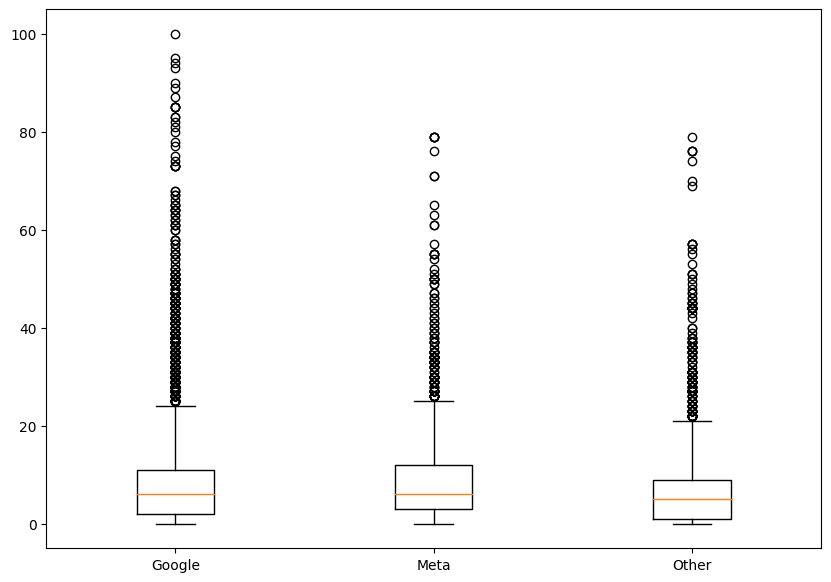

In [25]:
import matplotlib.pyplot as plt

conversion_time = conversion_time[conversion_time.conversion_time >= 0]

Google = conversion_time[conversion_time.marketing_source == 'Google']

Google = Google['conversion_time']

Meta = conversion_time[conversion_time.marketing_source == 'Meta']

Meta = Meta['conversion_time']

Other = conversion_time[conversion_time.marketing_source == 'Other']
 
Other = Other['conversion_time']

data = [Google, Meta, Other]

fig = plt.figure(figsize =(10, 7))


 
# Creating plot
plt.boxplot(data)
 
plt.xticks([1, 2, 3], ['Google', 'Meta', 'Other'])
# show plot
plt.show()

In [26]:
print('Percentile 25', 'Percentile 50', 'Percentile 75', 'Percentile 100', 'average')
print(array_info(Google))
print(array_info(Meta))
print(array_info(Other))

Percentile 25 Percentile 50 Percentile 75 Percentile 100 average
(2.0, 6.0, 11.0, 100.0, 8.575813036745037)
(3.0, 6.0, 12.0, 79.0, 9.572158365261814)
(1.0, 5.0, 9.0, 79.0, 7.993969298245614)


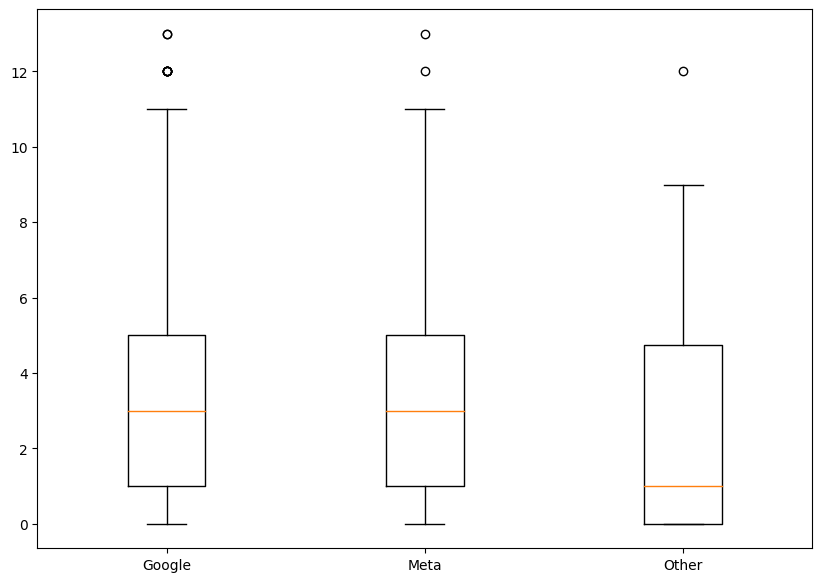

In [27]:
import matplotlib.pyplot as plt

conversion_time1 = conversion_time[conversion_time.month == 3]

Google = conversion_time1[conversion_time1.marketing_source == 'Google']

Google = Google['conversion_time']

Meta = conversion_time1[conversion_time1.marketing_source == 'Meta']

Meta = Meta['conversion_time']

Other = conversion_time1[conversion_time1.marketing_source == 'Other']
 
Other = Other['conversion_time']

data = [Google, Meta, Other]

fig = plt.figure(figsize =(10, 7))


 
# Creating plot
plt.boxplot(data)
 
plt.xticks([1, 2, 3], ['Google', 'Meta', 'Other'])
# show plot
plt.show()

In [28]:
print(array_info(Google))
print(array_info(Meta))
print(array_info(Other))

(1.0, 3.0, 5.0, 13.0, 3.25810635538262)
(1.0, 3.0, 5.0, 13.0, 3.3106060606060606)
(0.0, 1.0, 4.75, 12.0, 2.4523809523809526)


In [29]:
path = "generated_csv"

try:
   os.makedirs(path)
except FileExistsError:
   # directory already exists
   pass



In [30]:
Files_Path = (Path.cwd())
Files_Path = str(Files_Path) + "\\generated_csv"
Files_Path = Path(Files_Path)

In [31]:
conversion_time.to_csv('generated_csv\conversion_time.csv')

conversion_rate.to_csv('generated_csv\conversion_rate.csv')

CPAs.to_csv('generated_csv\CPAs.csv')

In [32]:
# AB Testing.

# The Student’s t-Test is a statistical hypothesis test for testing whether two samples are expected to have 
# been drawn from the same population.

# The test works by checking the means from two samples to see if they are significantly different from each other. 
# It does this by calculating the standard error in the difference between means, which can be interpreted to see
# how likely the difference is, if the two samples have the same mean (the null hypothesis).

In [33]:
lead_dataset_conversion_rate_saved = lead_dataset_conversion_rate
customer_dataset_conversion_rate_saved = customer_dataset_conversion_rate
call_dataset_conversion_rate_saved = call_dataset_conversion_rate

In [61]:
lead_dataset_conversion_rate = lead_dataset_conversion_rate_saved
customer_dataset_conversion_rate = customer_dataset_conversion_rate_saved
call_dataset_conversion_rate = call_dataset_conversion_rate_saved

In [62]:
#Global



In [63]:
call_dataset_conversion_rate = call_dataset_conversion_rate[['contact_id', 'trial_booked']]

lead_dataset_conversion_rate = lead_dataset_conversion_rate.merge(call_dataset_conversion_rate, how='inner', on=['contact_id']) 

lead_dataset_conversion_rate['create_date'] = pd.to_datetime(lead_dataset_conversion_rate['create_date'])

#lead_dataset_conversion_rate['year'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).year
#lead_dataset_conversion_rate['month'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).month

number_leads = lead_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_leads"})

lead_dataset_conversion_rate = lead_dataset_conversion_rate[['contact_id', 'create_date', 'trial_booked']]

customer_dataset_conversion_rate['customer_date'] = pd.to_datetime(customer_dataset_conversion_rate['customer_date'])

customer_dataset_conversion_rate = customer_dataset_conversion_rate.merge(lead_dataset_conversion_rate, how='inner', on=['contact_id']) 

number_customers = customer_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_customers"})

conversion_rate = number_customers.merge(number_leads, how='inner', on=['trial_booked', 'create_date']) 

In [64]:
alpha = 0.05

conversion_rate['CR%'] = conversion_rate['number_customers'] / conversion_rate['number_leads']

conversion_rate_trial = conversion_rate[(conversion_rate.trial_booked == 1)]

conversion_rate_no_trial = conversion_rate[(conversion_rate.trial_booked == 0)]

mean_trial = sum(conversion_rate_trial['number_customers']) / sum(conversion_rate_trial['number_leads']) 

mean_no_trial = sum(conversion_rate_no_trial['number_customers']) / sum(conversion_rate_no_trial['number_leads']) 

std_trial, std_no_trial = np.std(conversion_rate_trial['CR%'], ddof=1), np.std(conversion_rate_no_trial['CR%'], ddof=1)

n1, n2 = len(conversion_rate_trial), len(conversion_rate_no_trial)
se1, se2 = std_trial/np.sqrt(n1), std_no_trial/np.sqrt(n2)

sed = np.sqrt(se1**2.0 + se2**2.0)

t_stat = (mean_trial - mean_no_trial) / sed

# degrees of freedom
df = n1 + n2 - 2

alpha = 0.95
cv = t.ppf(1.0 - alpha, df)
p = (1 - t.cdf(abs(t_stat), df)) * 2

if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')
 
 
# source: https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/

Reject the null hypothesis that the means are equal.


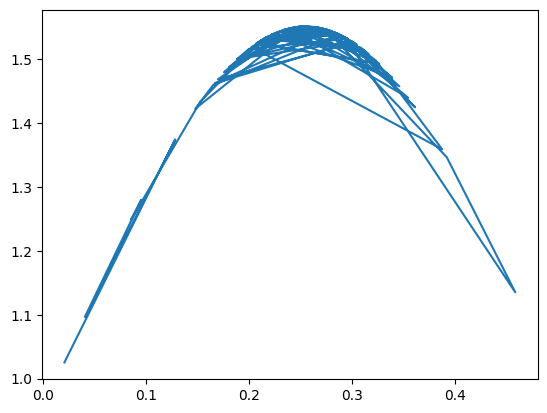

In [58]:
# looks like a normal

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = mean_trial
variance = std_trial
sigma = math.sqrt(variance)
x = conversion_rate_trial['CR%']
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

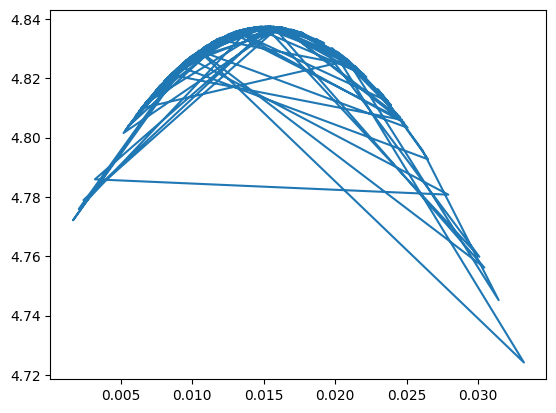

In [59]:
# looks like a normal

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = mean_no_trial
variance = std_no_trial
sigma = math.sqrt(variance)
x = conversion_rate_no_trial['CR%']
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [38]:
lead_dataset_conversion_rate = lead_dataset_conversion_rate_saved
customer_dataset_conversion_rate = customer_dataset_conversion_rate_saved
call_dataset_conversion_rate = call_dataset_conversion_rate_saved

In [39]:
#Google

lead_dataset_conversion_rate = lead_dataset_conversion_rate[(lead_dataset_conversion_rate.marketing_source == 'Google')]

call_dataset_conversion_rate = call_dataset_conversion_rate[['contact_id', 'trial_booked']]

lead_dataset_conversion_rate = lead_dataset_conversion_rate.merge(call_dataset_conversion_rate, how='inner', on=['contact_id']) 

lead_dataset_conversion_rate['create_date'] = pd.to_datetime(lead_dataset_conversion_rate['create_date'])

#lead_dataset_conversion_rate['year'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).year
#lead_dataset_conversion_rate['month'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).month

number_leads = lead_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_leads"})

lead_dataset_conversion_rate = lead_dataset_conversion_rate[['contact_id', 'create_date', 'trial_booked']]

customer_dataset_conversion_rate['customer_date'] = pd.to_datetime(customer_dataset_conversion_rate['customer_date'])

customer_dataset_conversion_rate = customer_dataset_conversion_rate.merge(lead_dataset_conversion_rate, how='inner', on=['contact_id']) 

number_customers = customer_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_customers"})

conversion_rate = number_customers.merge(number_leads, how='inner', on=['trial_booked', 'create_date']) 

alpha = 0.05

conversion_rate['CR%'] = conversion_rate['number_customers'] / conversion_rate['number_leads']

conversion_rate_trial = conversion_rate[(conversion_rate.trial_booked == 1)]

conversion_rate_no_trial = conversion_rate[(conversion_rate.trial_booked == 0)]

mean_trial = sum(conversion_rate_trial['number_customers']) / sum(conversion_rate_trial['number_leads']) 

mean_no_trial = sum(conversion_rate_no_trial['number_customers']) / sum(conversion_rate_no_trial['number_leads']) 

std_trial, std_no_trial = np.std(conversion_rate_trial['CR%'], ddof=1), np.std(conversion_rate_no_trial['CR%'], ddof=1)

n1, n2 = len(conversion_rate_trial), len(conversion_rate_no_trial)
se1, se2 = std_trial/np.sqrt(n1), std_no_trial/np.sqrt(n2)

sed = np.sqrt(se1**2.0 + se2**2.0)

t_stat = (mean_trial - mean_no_trial) / sed

# degrees of freedom
df = n1 + n2 - 2

alpha = 0.95
cv = t.ppf(1.0 - alpha, df)
p = (1 - t.cdf(abs(t_stat), df)) * 2

if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')
 
print(mean_trial)

print(mean_no_trial)

Reject the null hypothesis that the means are equal.
0.367544746387584
0.01913369499193599


In [40]:
lead_dataset_conversion_rate = lead_dataset_conversion_rate_saved
customer_dataset_conversion_rate = customer_dataset_conversion_rate_saved
call_dataset_conversion_rate = call_dataset_conversion_rate_saved

#Meta

lead_dataset_conversion_rate = lead_dataset_conversion_rate[(lead_dataset_conversion_rate.marketing_source == 'Meta')]

call_dataset_conversion_rate = call_dataset_conversion_rate[['contact_id', 'trial_booked']]

lead_dataset_conversion_rate = lead_dataset_conversion_rate.merge(call_dataset_conversion_rate, how='inner', on=['contact_id']) 

lead_dataset_conversion_rate['create_date'] = pd.to_datetime(lead_dataset_conversion_rate['create_date'])

#lead_dataset_conversion_rate['year'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).year
#lead_dataset_conversion_rate['month'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).month

number_leads = lead_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_leads"})

lead_dataset_conversion_rate = lead_dataset_conversion_rate[['contact_id', 'create_date', 'trial_booked']]

customer_dataset_conversion_rate['customer_date'] = pd.to_datetime(customer_dataset_conversion_rate['customer_date'])

customer_dataset_conversion_rate = customer_dataset_conversion_rate.merge(lead_dataset_conversion_rate, how='inner', on=['contact_id']) 

number_customers = customer_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_customers"})

conversion_rate = number_customers.merge(number_leads, how='inner', on=['trial_booked', 'create_date']) 

alpha = 0.05

conversion_rate['CR%'] = conversion_rate['number_customers'] / conversion_rate['number_leads']

conversion_rate_trial = conversion_rate[(conversion_rate.trial_booked == 1)]

conversion_rate_no_trial = conversion_rate[(conversion_rate.trial_booked == 0)]

mean_trial = sum(conversion_rate_trial['number_customers']) / sum(conversion_rate_trial['number_leads']) 

mean_no_trial = sum(conversion_rate_no_trial['number_customers']) / sum(conversion_rate_no_trial['number_leads']) 

std_trial, std_no_trial = np.std(conversion_rate_trial['CR%'], ddof=1), np.std(conversion_rate_no_trial['CR%'], ddof=1)

n1, n2 = len(conversion_rate_trial), len(conversion_rate_no_trial)
se1, se2 = std_trial/np.sqrt(n1), std_no_trial/np.sqrt(n2)

sed = np.sqrt(se1**2.0 + se2**2.0)

t_stat = (mean_trial - mean_no_trial) / sed

# degrees of freedom
df = n1 + n2 - 2

alpha = 0.95
cv = t.ppf(1.0 - alpha, df)
p = (1 - t.cdf(abs(t_stat), df)) * 2

if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')
 
print(mean_trial)

print(mean_no_trial)

Reject the null hypothesis that the means are equal.
0.18903061224489795
0.014454357735613823


In [41]:
lead_dataset_conversion_rate = lead_dataset_conversion_rate_saved
customer_dataset_conversion_rate = customer_dataset_conversion_rate_saved
call_dataset_conversion_rate = call_dataset_conversion_rate_saved

#Others

lead_dataset_conversion_rate = lead_dataset_conversion_rate[(lead_dataset_conversion_rate.marketing_source == 'Meta')]

call_dataset_conversion_rate = call_dataset_conversion_rate[['contact_id', 'trial_booked']]

lead_dataset_conversion_rate = lead_dataset_conversion_rate.merge(call_dataset_conversion_rate, how='inner', on=['contact_id']) 

lead_dataset_conversion_rate['create_date'] = pd.to_datetime(lead_dataset_conversion_rate['create_date'])

#lead_dataset_conversion_rate['year'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).year
#lead_dataset_conversion_rate['month'] = pd.DatetimeIndex(lead_dataset_conversion_rate['create_date']).month

number_leads = lead_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_leads"})

lead_dataset_conversion_rate = lead_dataset_conversion_rate[['contact_id', 'create_date', 'trial_booked']]

customer_dataset_conversion_rate['customer_date'] = pd.to_datetime(customer_dataset_conversion_rate['customer_date'])

customer_dataset_conversion_rate = customer_dataset_conversion_rate.merge(lead_dataset_conversion_rate, how='inner', on=['contact_id']) 

number_customers = customer_dataset_conversion_rate.groupby(by=['create_date', 'trial_booked'], as_index=False)[['contact_id']].count().rename(columns={"contact_id": "number_customers"})

conversion_rate = number_customers.merge(number_leads, how='inner', on=['trial_booked', 'create_date']) 

alpha = 0.05

conversion_rate['CR%'] = conversion_rate['number_customers'] / conversion_rate['number_leads']

conversion_rate_trial = conversion_rate[(conversion_rate.trial_booked == 1)]

conversion_rate_no_trial = conversion_rate[(conversion_rate.trial_booked == 0)]

mean_trial = sum(conversion_rate_trial['number_customers']) / sum(conversion_rate_trial['number_leads']) 

mean_no_trial = sum(conversion_rate_no_trial['number_customers']) / sum(conversion_rate_no_trial['number_leads']) 

std_trial, std_no_trial = np.std(conversion_rate_trial['CR%'], ddof=1), np.std(conversion_rate_no_trial['CR%'], ddof=1)

n1, n2 = len(conversion_rate_trial), len(conversion_rate_no_trial)
se1, se2 = std_trial/np.sqrt(n1), std_no_trial/np.sqrt(n2)

sed = np.sqrt(se1**2.0 + se2**2.0)

t_stat = (mean_trial - mean_no_trial) / sed

# degrees of freedom
df = n1 + n2 - 2

alpha = 0.95
cv = t.ppf(1.0 - alpha, df)
p = (1 - t.cdf(abs(t_stat), df)) * 2

if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')
 
print(mean_trial)

print(mean_no_trial)

Reject the null hypothesis that the means are equal.
0.18903061224489795
0.014454357735613823
